# Actividad: Problemas de regresión. (Aprendizaje Automático)

 Mi nombre es **Isai Ambrocio** con matrícula **A01625101** con lo cual me corresponde: Variable dependiente `VR`, variables independientes `M, W, H y S`.

# Ejercicio 1

## Planteamiento.

**El conjunto de datos de criminalidad de Estados Unidos publicado en el año 1993 consiste de 51 registros para los que se tienen las siguientes variables:**



* VR = crímenes violentos por cada 100000 habitantes.
* MR = asesinatos por cada 100000 habitantes.
* M = porcentaje de áreas metropolitanas.
* W = porcentaje de gente blanca.
* H = porcentaje de personas con preparatoria terminada.
* P = porcentaje con ingresos por debajo del nivel de pobreza.
* S = porcentaje de familias con solo un miembro adulto como tutor.



Librerias utilizadas.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy
from dataclasses import dataclass
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

sns.set_theme()

Importamos la base de datos, verificamos que se hayan exportado bien y verificamos que no hayan datos faltantes.

In [5]:
df = pd.read_csv("/content/crime_data.csv")

In [6]:
df.head()

,State,VR,MR,M,W,H,P,S
0,AK,761,9.0,41.8,75.2,86.6,9.1,14.3
1,AL,780,11.6,67.4,73.5,66.9,17.4,11.5
2,AR,593,10.2,44.7,82.9,66.3,20.0,10.7
3,AZ,715,8.6,84.7,88.6,78.7,15.4,12.1
4,CA,1078,13.1,96.7,79.3,76.2,18.2,12.5


In [7]:
df.isna().sum()

State    0
VR       0
MR       0
M        0
W        0
H        0
P        0
S        0
dtype: int64

1. Grafica cada variable predictora vs la variable de respuesta asignadas a tu número de matrícula.

In [8]:
columnas_a_mantener = ["M", "W", "H", "S"]
var_independientes = df.drop("VR", axis=1).loc[:, columnas_a_mantener]
var_dependiente = df["VR"]

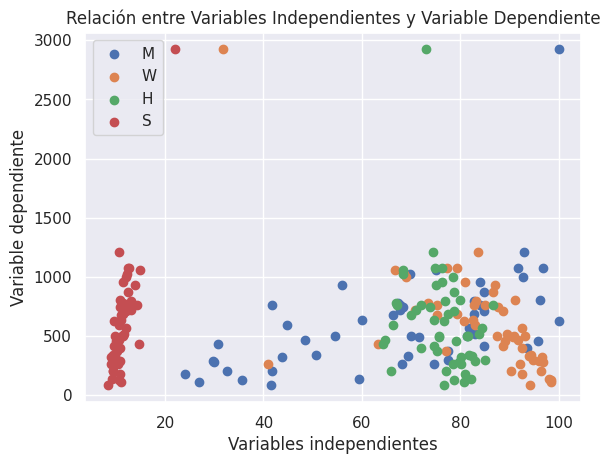

In [9]:
for columna in var_independientes:
    plt.scatter(df[columna], var_dependiente, label=columna)

plt.xlabel("Variables independientes")
plt.ylabel("Variable dependiente")
plt.title("Relación entre Variables Independientes y Variable Dependiente")
plt.legend()
plt.show()

2. Implementa la fórmula directa para calcular los coeficientes de un modelo de regresión lineal, y obtenga con ella el modelo que corresponde a la variable de respuesta y las variables predictoras asignadas a tu número de matrícula.


In [10]:
X = pd.concat([pd.Series(np.ones(len(var_independientes)), name="intercept"),
               var_independientes], axis=1).values
Y = var_dependiente.copy().values
print(X.shape)

(51, 5)


In [11]:
np.ones(X.shape[1])

array([1., 1., 1., 1., 1.])

In [12]:
(X.T @ X @ np.ones(X.shape[1]) - (X.T @ Y)) * 1e-15

array([-1.90126000e-11, -1.52494484e-09, -1.39693506e-09, -1.41496596e-09,
       -2.54801020e-10])

In [13]:
@dataclass
class ValidationMetrics:
    r2_hist = []
    mae_hist = []
    mse_hist = []
    r2 = 0
    mae = 0
    mse = 0


class MyLinearRegression:

    def __init__(self):
        self.coefs = None

    def get_params(self, deep: bool = True):
        if self.coefs is not None:
            return {f"beta_{i}": self.coefs[i] for i in range(len(self.coefs))}
        return {}

    def fit(self, x: np.array, y: np.array) -> 'LinearRegression':
        self.coefs = np.linalg.inv((x.T @ x)) @ x.T @ y
        return self

    def fit_ridge(self, x: np.array, y: np.array, alpha: float = 0.001, lam: float = 000.1, tol: float = 1e-5, verbose: bool = False) -> 'LinearRegression':
        n, p = x.shape

        model = MyLinearRegression()
        model.coefs = np.ones(p)

        j_hist = [(1 / n) * ((model.predict(x) - y) @ (model.predict(x) - y))]

        i = 0

        while True:
            y_hat = model.predict(x)

            if verbose:
                if i % 100 == 0:
                    err = sum(y_hat - y) / n
                    print(f"Coefs: {model.coefs}\tErr: {err}")

            djdb = (1 / n) * (x.T @ (y_hat - y)) + lam * model.coefs
            coefs_1 = model.coefs - alpha * djdb
            j = (1 / n) * ((x @ coefs_1 - y) @ (x @ coefs_1 - y))

            if abs((j - j_hist[-1]) / j) < tol:
                print(f"Reached tolerance at {i} iterations")
                break

            j_hist.append(j)
            model.coefs = coefs_1
            i += 1

            if i == 100_000:
                break

        self.coefs = coefs_1

        return self

    def predict(self, x: np.array) -> np.array:
        return x @ self.coefs

    def cross_validate(self, x: np.array, y: np.array, k: int):
        """ Aplicando k-fold cross validation.

        Parameteros
        ----------
        x : np.array
            contiene las variables independiente .
        y : np.array
            contiene la variable dependiente.
        k : int
            número de pliegues

        Returns
        -------
        dict : contiene las metricas R2, MSE, MAE.
        """

        kf = KFold(n_splits=k)

        r2 = 0
        mse = 0
        mae = 0

        metrics_report = ValidationMetrics()

        for train_idx, test_idx in kf.split(x, y):
            x_train = x[train_idx]
            y_train = y[train_idx]

            x_test = x[test_idx]
            y_test = y[test_idx]

            self.fit(x_train, y_train)
            y_hat = self.predict(x_test)

            r2 += r2_score(y_test, y_hat)
            mse += mean_squared_error(y_test, y_hat)
            mae += mean_absolute_error(y_test, y_hat)

            metrics_report.mae_hist.append(mean_absolute_error(y_test, y_hat))
            metrics_report.mse_hist.append(mean_squared_error(y_test, y_hat))
            metrics_report.r2_hist.append(r2_score(y_test, y_hat))

        metrics_report.mae = mae / k
        metrics_report.mse = mse / k
        metrics_report.r2 = r2 / k

        return metrics_report

    def leave_one_out_cv(self, x: np.array, y: np.array):
        """ Aplicando Leave-One-Out cross validation.

        Parametros
        ----------
        x : np.array
            contiene las variables independiente .
        y : np.array
            contiene la variable dependiente.

        Returns
        -------
        dict : contiene las metricas MSE, MAE.
        """
        loo = LeaveOneOut()

        mse = 0
        mae = 0

        metrics_report = ValidationMetrics()

        for train_idx, test_idx in loo.split(x):
            x_train = x[train_idx]
            y_train = y[train_idx]

            x_test = x[test_idx]
            y_test = y[test_idx]

            self.fit(x_train, y_train)
            y_hat = self.predict(x_test)

            mse += mean_squared_error(y_test, y_hat)
            mae += mean_absolute_error(y_test, y_hat)

            metrics_report.mae_hist.append(mean_absolute_error(y_test, y_hat))
            metrics_report.mse_hist.append(mean_squared_error(y_test, y_hat))

        num_samples = x.shape[0]

        metrics_report.mae = mae / num_samples
        metrics_report.mse = mse / num_samples

        return metrics_report


    def score(self, x: np.array, y: np.array) -> float:
        y_hat = self.predict(x)
        return r2_score(y, y_hat)

    def __repr__(self) -> str:
        if self.coefs is not None:
            return "Linear Regression Model:\n" + "".join([f"\tbeta_{i} = {self.coefs[i]};\n" for i in range(len(self.coefs))])
        return "Unfitted Linear Regression Model"

    def __str__(self) -> str:
        if self.coefs is not None:
            return f"y_hat = ({self.coefs[0]})" + "".join([f" + ({self.coefs[i]})x_{i}" for i in range(1, len(self.coefs))])
        return "Unfitted Linear Regression Model"

In [14]:
model = MyLinearRegression().fit(X, Y)
print(model)

y_hat = (-700.8657777938025) + (6.756224749301047)x_1 + (-3.2750565131822666)x_2 + (-5.841564740427037)x_3 + (139.43133571994844)x_4


3. Evalúa con validación cruzada de k-pliegues tu modelo, calculando los valores de R2, MSE y MAE.

In [15]:
cv_kfold = model.cross_validate(X, Y, 4)
print(f"R2: {cv_kfold.r2}\nMSE: {cv_kfold.mse}\nMAE: {cv_kfold.mae}")

R2: 0.4237149323893757
MSE: 68367.82014499554
MAE: 184.09786824566177


4. Utiliza el método de validación cruzada asignado a tu matrícula para mostrar los histogramas de R2, MSE y MAE. **Metodo asignado: *LOOCV***

In [16]:
cv_loo = model.leave_one_out_cv(X, Y)
print(f"MSE: {cv_loo.mse}\nMAE: {cv_loo.mae}")

MSE: 60094.47324811131
MAE: 171.00445043216695


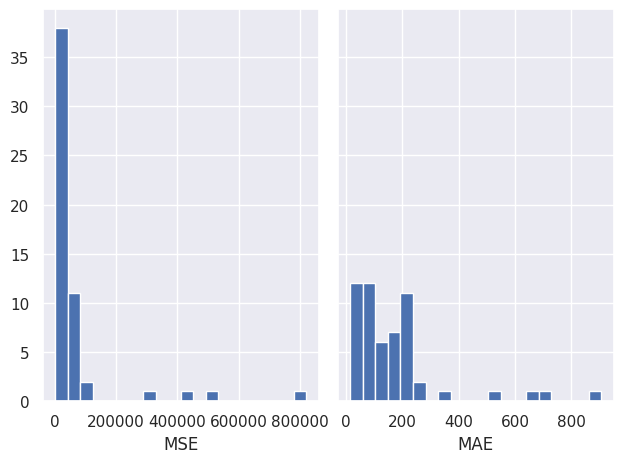

In [17]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(cv_loo.mse_hist, bins=20)
axs[0].set_xlabel("MSE")
axs[1].hist(cv_loo.mae_hist, bins=20)
axs[1].set_xlabel("MAE")
plt.show()

5. Agrega al conjunto de datos columnas que representen los cuadrados de las variables predictoras (por ejemplo, M2, W2), así como los productos entre pares de variables (por ejemplo, PxS, MxW). Repita los pasos 1, 2 y 3 pero con este nuevo conjunto de datos.

In [18]:
df1 = df.copy()
df1["M2"] = df1["M"] ** 2
df1["W2"] = df1["W"] ** 2
df1["H2"] = df1["H"] ** 2
df1["S2"] = df1["S"] ** 2

df1["MxW"] = df1["M"] * df["W"]
df1["MxH"] = df1["M"] * df["H"]
df1["MxS"] = df1["M"] * df["S"]
df1["WxH"] = df1["W"] * df["H"]
df1["WxS"] = df1["W"] * df["S"]
df1["HxS"] = df1["H"] * df["S"]

In [19]:
columnas_a_mantener2 = ["M", "W", "H", "S", "M2", "W2", "H2", "S2","MxW", "MxH", "MxS", "WxH", "WxS", "HxS"]
var_independientes2 = df1[columnas_a_mantener2]
var_dependiente2 = df1["VR"]

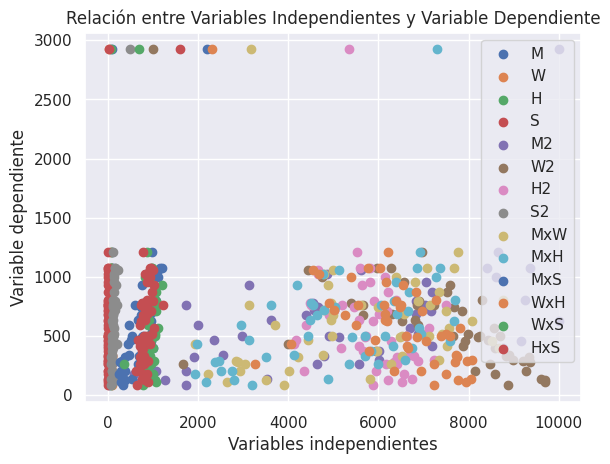

In [20]:
for columna in var_independientes2:
    plt.scatter(df1[columna], var_dependiente2, label=columna)

plt.xlabel("Variables independientes")
plt.ylabel("Variable dependiente")
plt.title("Relación entre Variables Independientes y Variable Dependiente")
plt.legend()
plt.show()

In [21]:
X2 = pd.concat([pd.Series(np.ones(len(var_independientes2)), name="intercept"),
               var_independientes2], axis=1).values
Y2 = var_dependiente2.copy().values
print(X2.shape)

(51, 15)


In [22]:
model2 = MyLinearRegression().fit(X2, Y2)
print(model2)

y_hat = (3962.1845219077877) + (27.52551457990444)x_1 + (56.770066506190005)x_2 + (-100.70045437856007)x_3 + (-509.5504415868036)x_4 + (-0.005506348724461311)x_5 + (-0.4502443468294728)x_6 + (0.4272475074213877)x_7 + (12.557624351349082)x_8 + (-0.2558325274271582)x_9 + (-0.14530133180344038)x_10 + (1.1425157074678463)x_11 + (0.19310176506633936)x_12 + (0.9111025546159941)x_13 + (2.077703924339154)x_14


In [23]:
cv_kfold = model2.cross_validate(X2, Y2, 4)
print(f"R2: {cv_kfold.r2}\nMSE: {cv_kfold.mse}\nMAE: {cv_kfold.mae}")

R2: -0.5228098749172991
MSE: 266721.6039429186
MAE: 247.62511556599992


6. Implementa regresión Ridge con descenso de gradiente, y genera el gráfico de Ridge para el conjunto de datos original (sin las variables elevadas al cuadrado).

In [24]:
ridge_lambdas = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
ridge_coefs = np.array([MyLinearRegression().fit_ridge(X, Y, alpha=0.0001, lam=lam, tol=1e-6).coefs for lam in ridge_lambdas])

Reached tolerance at 8891 iterations
Reached tolerance at 8972 iterations
Reached tolerance at 9716 iterations
Reached tolerance at 10994 iterations
Reached tolerance at 4453 iterations
Reached tolerance at 590 iterations
Reached tolerance at 91 iterations


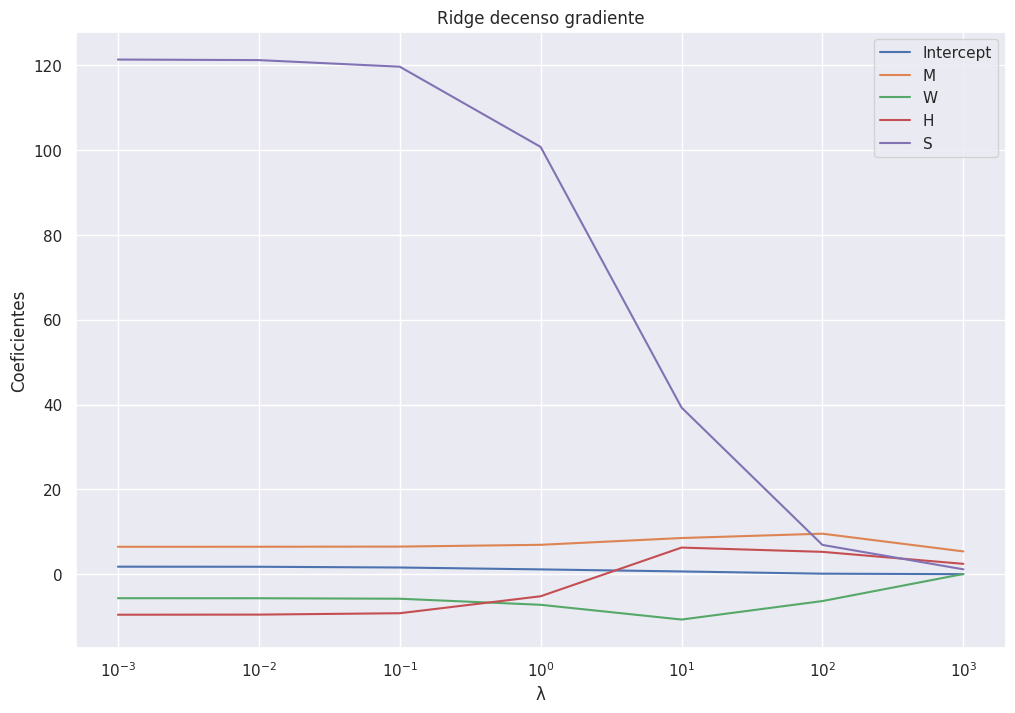

In [25]:
labels = ["Intercept"] + columnas_a_mantener
plt.figure(figsize=(12, 8))
for i in range(ridge_coefs.shape[1]):
    plt.plot(ridge_lambdas, ridge_coefs[:, i], label = f"{labels[i]}")

plt.title("Ridge decenso gradiente")
plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coeficientes")
plt.legend()
plt.show()

7. Utiliza una librería para generar el gráfico de Lasso para el conjunto
de datos original (sin las variables elevadas al cuadrado). ¿Qué variables son más relevantes para el modelo?

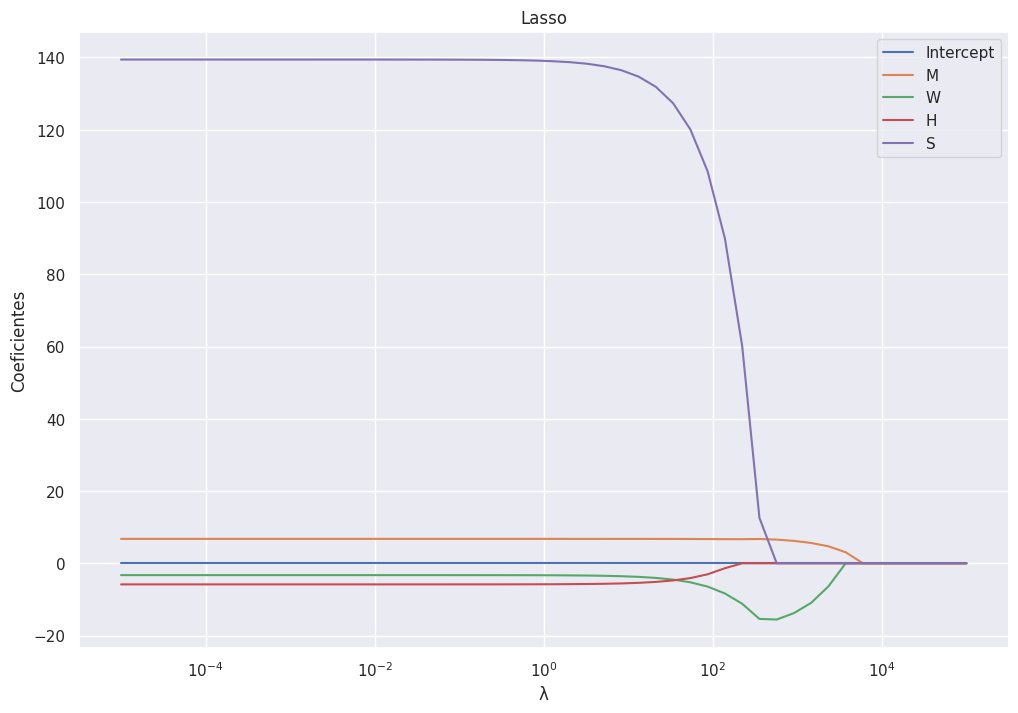

In [26]:
x = np.column_stack([np.ones(len(df)), df["M"], df["W"], df["H"], df["S"]])
y = df["VR"]

coefficients = []

alphas = np.logspace(-5, 5, 50)

for alpha in alphas:
    lasso = Lasso(alpha = alpha)
    lasso.fit(x, y)
    coefficients.append(lasso.coef_)

plt.figure(figsize=(12, 8))
feature_names = ["Intercept", "M", "W", "H", "S"]

for i in range(x.shape[1]):
    plt.plot(alphas, [coef[i] for coef in coefficients], label=feature_names[i])

plt.title("Lasso")
plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coeficientes")
plt.legend()
plt.show()

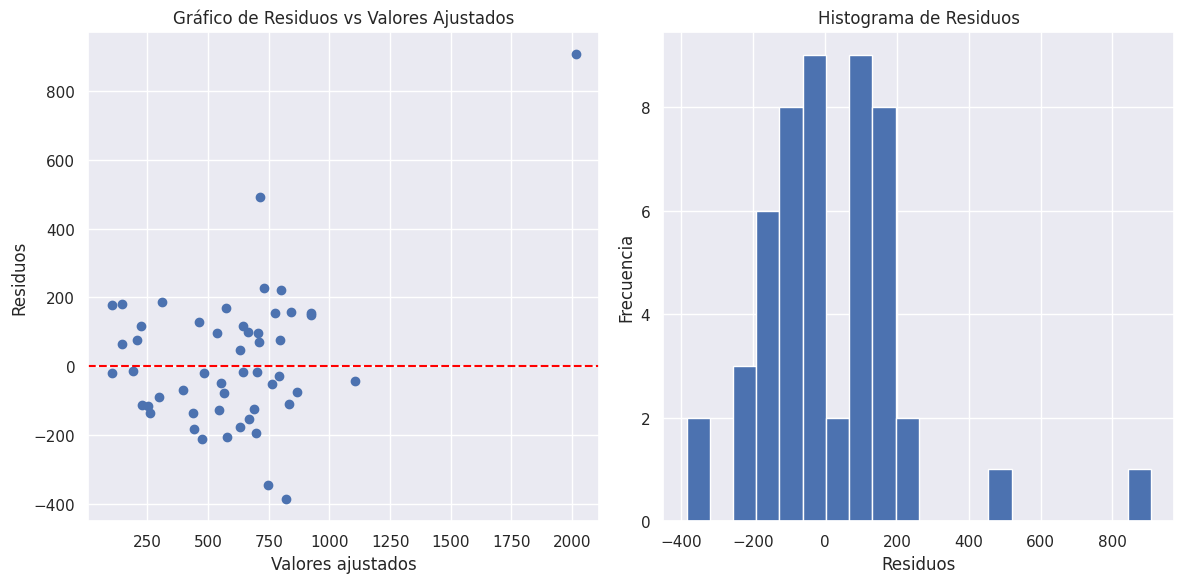

In [27]:
residuos = y - model.predict(X)

# Gráficos de residuos
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(model.predict(X), residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs Valores Ajustados')

plt.subplot(1, 2, 2)
plt.hist(residuos, bins=20)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')

plt.tight_layout()
plt.show()

8. Viendo los resultados de regresión, desarrolla una conclusión sobre los siguientes puntos:
¿Consideras que el modelo de regresión lineal es efectivo para modelar los datos del problema? ¿Por qué?
¿Observas una variabilidad importante en los valores de R2, MSE y MAE cuando aplicas validación cruzada?
¿Qué modelo es mejor para los datos de criminalidad, el lineal o el cuadrático? ¿Por qué?
¿Qué variables son más relevantes para el modelo según Ride y Lasso?
¿Encuentras alguna relación interesante entre la variable de respuesta y los predictores?

### Preguntas

1. **¿Consideras que el modelo de regresión lineal es efectivo para modelar los datos del problema? ¿Por qué?**

Considero que el modelo no es efectivo para modelar los datos de este problema, esto se debe a varios factores, pero dos primordiales. Uno es la escasa cantidad de datos que tenemos y el segundo es el resultado de R2, MSE y MAE.



* `R2` Tuvo resultado de: 0.423
* `MSE` Tuvo resultado de: 68367.8 y 60094.47
* `MAE` Tuvo resultado de: 184.09 y 171.004

Podemos observar que R2 estuvo muy por debajo para ser considerado efectivo. Por su parte, MSE está muy alejado de 3000 y MAE también es un valor bastante alto.

2. **¿Observas una variabilidad importante en los valores de R2, MSE y MAE cuando aplicas validación cruzada?**

Sí, hay una variabilidad importante de los valores al aplicar validación cruzada, debido a que al utilizar esta técnica en lugar de tener solo un par de conjuntos de entrenamiento y prueba, la validación cruzada involucra la creación de varios conjuntos de entrenamiento y prueba a partir de los datos disponibles. Esto nos permite que el modelo se entrene y evalúe en diferentes subconjuntos de datos, lo que ayuda a abordar problemas potenciales de sesgo y varianza.

3. **¿Qué modelo es mejor para los datos de criminalidad, el lineal o el cuadrático?**

Dado que no hubo variaciones significativas entre ambos modelos, por **principio de parsimonia** nos quedaremos con un modelo más sencillo que pueda explicar lo mismo, es decir, el modelo lineal.


4 - 5. **¿Qué variables son más relevantes para el modelo según Ride y Lasso? ¿Encuentras alguna relación interesante entre la variable de respuesta y los predictores?**

En el caso del modelo Ridge las más relevantes fueron M = porcentaje de áreas metropolitanas, W = porcentaje de gente blanca, H = porcentaje de personas con preparatoria terminada.
Por parte de Lasso, fueorn M = porcentaje de áreas metropolitanas, W = porcentaje de gente blanca.

Sin embargo, vemos que en los casos de W y H es inversamente proporcional, así que al realizar la penalización($\lambda$)  dichos paramtros en la gráfica empiezan a incrementar lo que nos indica que el sector fuera de W y H, es decir 1-W y 1-H tienen mayor repercusión en el asunto.

# Ejericio 2

## Planteamiento

El conjunto de datos de esperanzas de vida (Life Expectancy) tiene el registro de la esperanza de vida de 193 países medida en diferentes años, junto con otras variables que se pueden relacionar con riesgos a la salud y la mortalidad. Para este ejercicio, sólo se considerará como variable dependiente la cuarta columna ("Life expectancy"). A su vez, las variables independientes de interés son:

* X1 - Adult mortality
* X2 - Infant deaths
* X3 - Alcohol
* X4 - Percentage expenditure
* X5 - Hepatitis B
* X6 - Measles
* X7 - BMI
* X8 - Under-five deaths
* X9 - Polio
* X10 - Total expenditure
* X11 - Diphtheria
* X12 - HIV/AIDS   
* X13 - GDP
* X14 - Population
* X15 - Thinness  1-19 years
* X16 - Thinness 5-9 years
* X17 - Income composition of resources
* X18 - Schooling

**Nota 1: Las variables con las que vas a trabajar depende del penúltimo número de tu matrícula de acuerdo a la siguiente lista:**

0, 1 - Todas las variables, menos X1, X5, X9, X13, X17



1. Evalúa con validación cruzada un modelo de regresión lineal para las variables asignadas según tu matrícula utilizando alguna librería o framework.

In [28]:
df_edv = pd.read_csv("/content/Life_Expectancy_Data.csv")

In [29]:
df_edv.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Aquí filtro los datos de acuerdo a mi matricula.

In [30]:
columnas_interes = ["Adult Mortality", "Hepatitis B", "Polio", "GDP", "Income composition of resources"]
variables_independientes = df_edv.drop("Life expectancy ", axis=1).loc[:, columnas_interes]
variable_dependiente = df_edv["Life expectancy "]

Analizamos cuales columnas no tienen valores.

In [31]:
variables_independientes.isna().sum()

Adult Mortality                     10
Hepatitis B                        553
Polio                               19
GDP                                448
Income composition of resources    167
dtype: int64

In [32]:
variable_dependiente.isna().sum()

10

Como podemos observar, hay muchos datos faltantes. Al no tener un data set con muchos datos no es conveniente eliminarlos, por lo cual haremos una imputación simple.

In [33]:
imputer_ind = SimpleImputer(strategy="mean")
imputer_dep = SimpleImputer(strategy="mean")

In [34]:
variables_independientes_imputed = imputer_ind.fit_transform(variables_independientes)
variable_dependiente_imputed = imputer_dep.fit_transform(variable_dependiente.values.reshape(-1,1))

1. Evalúa con validación cruzada un modelo de regresión lineal para las variables asignadas según tu matrícula utilizando alguna librería o framework.

In [35]:
model_edv = LinearRegression().fit(variables_independientes_imputed, variable_dependiente_imputed)

In [36]:
model_edv.score(variables_independientes_imputed, variable_dependiente_imputed)

0.7073528901519579

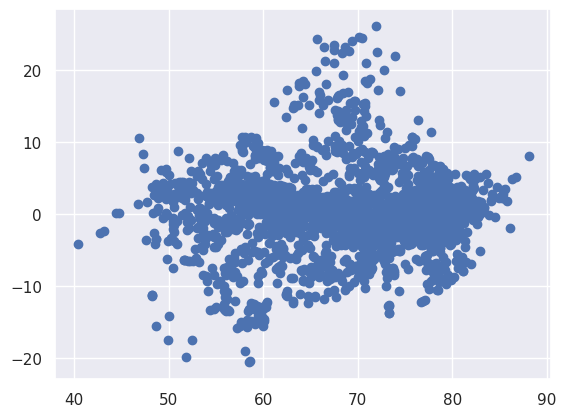

In [37]:
y_hat_edv = model_edv.predict(variables_independientes_imputed)
err = y_hat_edv - variable_dependiente_imputed
plt.scatter(y_hat_edv, err)
plt.show()

In [38]:
scores_edv = cross_val_score(model_edv, variables_independientes_imputed, variable_dependiente_imputed,
                             cv = 5, scoring = "neg_mean_squared_error")

In [39]:
scores_edv

array([-28.6985754 , -25.92045514, -21.03107001, -27.02459853,
       -33.08660532])

In [40]:
average_mse = -scores_edv.mean()
print("Average Negative Mean Squared Error:", average_mse)

Average Negative Mean Squared Error: 27.152260881987974


2. Encuentra el número óptimo de predictores para el modelo utilizando el método filter y validación cruzada. Una vez que tengas el número óptimo, muestra las características seleccionadas.

In [41]:
max_predictors = len(columnas_interes)
best_score = float("inf")
best_predictors = []

In [42]:
for num_predictors in range(1, max_predictors + 1):
    selected_predictors = variables_independientes_imputed[:, :num_predictors]

    scores_edv_predictor = cross_val_score(model_edv, selected_predictors,
                                           variable_dependiente_imputed,
                                           cv=5, scoring="neg_mean_squared_error")

In [43]:
average_mse_predictor = -scores_edv_predictor.mean()

In [44]:
if average_mse_predictor < best_score:
        best_score = average_mse_predictor
        best_predictors = columnas_interes[:num_predictors]

print("Best Predictors:", best_predictors,num_predictors)
print("Best Negative Mean Squared Error:", best_score)

Best Predictors: ['Adult Mortality', 'Hepatitis B', 'Polio', 'GDP', 'Income composition of resources'] 5
Best Negative Mean Squared Error: 27.152260881987974


3. Repite el paso anterior pero con selección de características secuencial (Wrapper). Reporta los predictores óptimos encontrados por el método.

In [ ]:
sfs = SequentialFeatureSelector(model_edv,
                                k_features=(1, len(columnas_interes)),
                                forward=False,
                                floating=False,
                                scoring="neg_mean_squared_error",
                                cv=5)

sfs.fit(variables_independientes_imputed, variable_dependiente_imputed)

In [46]:
selected_indices = list(sfs.k_feature_idx_)
selected_predictors = [columnas_interes[idx] for idx in selected_indices]

print("Selected Predictors:", selected_predictors)

Selected Predictors: ['Adult Mortality', 'Polio', 'GDP', 'Income composition of resources']


4. Haz el mismo proceso del paso 2, pero ahora con el método de selección de características recursivo (Filter-Wrapper). Reporta los predictores óptimos encontrados por el método.

In [47]:
rfecv = RFECV(estimator=model_edv, cv=5, scoring="neg_mean_squared_error")

In [ ]:
rfecv.fit(variables_independientes_imputed, variable_dependiente_imputed)

> Obtener los índices de las características seleccionadas y los nombres de las características seleccionadas.

In [49]:
selected_indices = rfecv.support_
selected_predictors_2 = [columnas_interes[idx] for idx,
                       is_selected in enumerate(selected_indices) if is_selected]

print("Selected Predictors:", selected_predictors_2)

Selected Predictors: ['Adult Mortality', 'Hepatitis B', 'Polio', 'GDP', 'Income composition of resources']


5. Repita los pasos anteriores, pero utilizando un modelo de regresión no lineal como K-vecinos más cercanos.

In [50]:
model_edv = KNeighborsRegressor(n_neighbors=5)

In [51]:
sfs_2 = SequentialFeatureSelector(model_edv,
                                k_features=(1, len(columnas_interes)),
                                forward=False,
                                floating=False,
                                scoring="neg_mean_squared_error",
                                cv=5)

In [ ]:
sfs_2.fit(variables_independientes_imputed, variable_dependiente_imputed)

In [53]:
selected_indices = list(sfs_2.k_feature_idx_)
selected_predictors_3 = [columnas_interes[idx] for idx in selected_indices]

print("Selected Predictors:", selected_predictors_3)

Selected Predictors: ['Adult Mortality', 'Income composition of resources']


6. Agregue la variables "Status" (segunda columna) como variable predictora, y utiliza un árbol de decisión para generar un modelo de regresión para la varible Life expectancy". Evalúa este modelo con validación cruzada utilizando la métrica adecuada.

In [54]:
columnas_interes = ["Status", "Adult Mortality", "Hepatitis B", "Polio", "GDP", "Income composition of resources"]

In [55]:
variables_independientes = df_edv[columnas_interes]
variable_dependiente = df_edv["Life expectancy "]

In [56]:
variables_independientes = pd.get_dummies(variables_independientes, columns=["Status"], drop_first=True)

In [57]:
imputer = SimpleImputer(strategy="mean")
variables_independientes_imputed = imputer.fit_transform(variables_independientes)

In [64]:
model_edv_tree = DecisionTreeRegressor()

In [65]:
scores_edv_tree = cross_val_score(model_edv_tree, variables_independientes_imputed, variable_dependiente_imputed, cv=5, scoring="r2")
scores_edv_tree_2 = cross_val_score(model_edv_tree, variables_independientes_imputed, variable_dependiente_imputed, cv=5, scoring="neg_mean_squared_error")

average_r2 = scores_edv_tree.mean()
mse = -scores_edv_tree_2.mean()
print("Average R2:", average_r2)
print("MSE:", mse)

Average R2: 0.8493359856771635
MSE: 13.43941214292864


### Preguntas

7. Viendo los resultados de este ejercicio, escriba una conclusión sobre los siguientes puntos:
Consideras que el modelo de regresión lineal es adecuado para los datos. ¿Por qué?
¿Qué método de selección de características consideras que funciona bien con los datos? ¿Por qué?
Del proceso de selección de características, ¿puedes identificar algunas que sean sobresalientes? ¿Qué información relevantes observas de dichas características?
¿El modelo de regresión no lineal funcionó mejor que el lineal? ¿Por qué?
¿Notas alguna mejora con el árbol de decisión al agregar la variable categórica "Status"? ¿Por qué?
¿Se puede concluir algo interesante sobre los resultados de modelar estos datos con regresión? Argumenta tu respuesta.



1.   **Consideras que el modelo de regresión lineal es adecuado para los datos. ¿Por qué?**

Deacuerdo a los resultados obtenidos de los modelos es un modelo decente llegando a bueno. Porque las ponderaciones de `Best Negative Mean Squared Error` y `R2` fueron muy decentes. Además, los tiempos de procesamiento no fueron largos.

2.   **¿Qué método de selección de características consideras que funciona bien con los datos? ¿Por qué?**

Todos fueron muy parecidos en cuanto a la selección de características y puntajes, exceptuando el de k-vecinos más cercanos. Que dio un mejor resultado de R2, pero solo tomo como importante `Adult Mortality` e `Income composition of resources`

3.   **Del proceso de selección de características, ¿puedes identificar algunas que sean sobresalientes? ¿Qué información relevantes observas de dichas características?**

Considero que los datos que mejor funcionan son: `Adult Mortality`, `Income composition of resources`. Esto se debe a que fueron los más relevantes según las observaciones que se realizaron. Por otro lado, tiene sentido debido a que se ve mermada la salud de una persona que esta restringida de recursos. No tendra buena vivienda, la posibilidad de pagar medicamentos y sobre todo una precaria alimentación.

 4. **¿El modelo de regresión no lineal funcionó mejor que el lineal? ¿Por qué?**

En efecto, el modelo no lineal fue mejor que el lineal, esto se debe a que los datos no presentan alta correlación. Además, al utilizar un árbol de decisiones puede manejar de mejor manera los outlayers, pero como desventaja puede ocurrir over fit o estar muy sesgado.   


 5. **¿Notas alguna mejora con el árbol de decisión al agregar la variable categórica "Status"? ¿Por qué?**

 Sí, hubo una mejora considerable al agregar la variable `Status` ya que R2 más alto y el MSE más bajo, es decir, que tuvieron mejores puntajes, por ende, el modelo está ajustando mejor los datos de entrenamiento y sus predicciones se acercan más a los valores reales.

 En este caso particular, `Status` está aportando información adicional que el modelo puede utilizar para hacer mejores predicciones sobre la esperanza de vida.

 6. **¿Se puede concluir algo interesante sobre los resultados de modelar estos datos con regresión?**

Pienso que sí. Cómo mencioné con anterioridad `Adult Mortality`, `Income composition of resources` fueron las características de mayor peso y siguiendo el pensamiento lógico que planteé, el no tener una buena composición de ingreso de recursos desprende a otra parte de los factores como atender enfermedades, buena alimentación, etc.